### Understand the CRF code and the feature_mapper code.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from lxmls import DATA_PATH
import lxmls
import lxmls.sequences.crf_online as crfo
import lxmls.readers.pos_corpus as pcc
import lxmls.sequences.id_feature as idfc
import lxmls.sequences.extended_feature as exfc
from lxmls.readers import pos_corpus

Load data from the conll task

In [3]:
corpus = lxmls.readers.pos_corpus.PostagCorpus()

train_seq = corpus.read_sequence_list_conll(DATA_PATH + "/train-02-21.conll", 
                                            max_sent_len=10, max_nr_sent=1000)

test_seq = corpus.read_sequence_list_conll(DATA_PATH + "/test-23.conll", 
                                           max_sent_len=10, max_nr_sent=1000)

dev_seq = corpus.read_sequence_list_conll(DATA_PATH + "/dev-22.conll", 
                                          max_sent_len=10, max_nr_sent=1000)

In [4]:
print("There are", len(train_seq), "examples in train_seq")
print("First example:", train_seq[0])

There are 1000 examples in train_seq
First example: Ms./noun Haag/noun plays/verb Elianti/noun ./. 


### Feature generation

Given a dataset, in order to build the features

- An instance from **`lxmls.sequences.id_feature.IDFeatures(train_data)`** must be instanciated. We will call `feature_mapper` this instanciated object.
- Then **`feature_mapper.build_features()`** must be executed


In [5]:
## Building features
feature_mapper = idfc.IDFeatures(train_seq)
feature_mapper.build_features()



#### About feature_mappers
A ```feature_mapper``` will contain the following attributes:

- the dataset in ```.dataset```
    - if we instantiate the feature mapper with a dataset X then ```feature_mapper.dataset```will be a copy of X


- a dictionary of features in ```.feature_dict```
    - this dictionary will default to ```{}```. 
    - In order to build the features the feature mapper must call ```.build_features()``` function.
    
    
- a list of features in ```.feature_list```
    - this list will default to ```[]```. 
    - In order to build the list of features the feature mapper must call ```.build_features()``` function.

A ```feature_mapper``` will contain the method 

- A method to generate features, ```.build_features```
    - this method will create features using the ```.dataset``.
    - This method will also fill ```.feature_dict``` and ```.feature_list``




In [9]:
len(feature_mapper.feature_list)

1000

In [10]:
## Let's see the features for the first training example
feature_mapper.feature_list[0]

[[[0]], [[3], [5], [7], [9]], [[10]], [[1], [2], [4], [6], [8]]]

In [11]:
## The previous features can be classified into:

print("\nInitial features:",     feature_mapper.feature_list[0][0])
print("\nTransition features:",  feature_mapper.feature_list[0][1])
print("\nFinal features:",       feature_mapper.feature_list[0][2])
print("\nEmission features:",    feature_mapper.feature_list[0][3])


Initial features: [[0]]

Transition features: [[3], [5], [7], [9]]

Final features: [[10]]

Emission features: [[1], [2], [4], [6], [8]]


#### An observation on the features for a given example

All features for all the training examples in are saved in `train_seq` will be saved in ``feature_mapper.feature_list``.

# IMPORTANT!!!!!!

- If `feature_mapper.feature_list[m]` is our feature vector for training example `m`... why it's not a vector?

    - Good point! In order to make the algorithm fast, **the code is written using dicts, so if we access only a few positions from the dict and compute substractions it will be much faster than computing the substraction of two huge weight vectors**. Notice that there are `len(feature_mapper.feature_dict)` features.

In [12]:
len(train_seq), len(feature_mapper.feature_list)

(1000, 1000)

- This feature_list is just a sparse matrix represented as a dict

### Codification of the features


Features are identifyed by **init_tag:**, **prev_tag:**,  **final_prev_tag:**, **id:**

- **init_tag:** when they are Initial features
    - Example: **``init_tag:noun``** is an initial feature that describes that the first word is a noun
    
    
- **prev_tag:** when they are transition features
    - Example: **``prev_tag:noun::noun``** is an transition feature that describes that the previous word was
      a noun and the current word is a noun.
    - Example: **``prev_tag:noun:.``** is an transition feature that describes that the previous word was
      a noun and the current word is a `.` (this is usually foud as the last transition feature since most phrases will end up with a dot)
      


- **final_prev_tag:** when they are final features
    - Example: **``final_prev_tag:.``** is a final feature stating that the last "word" in the sentence was a dot.


- **id:** when they are emission features
    - Example: **``id:plays::verb``** is an emission feature, describing that the current word is plays and the current hidden state is a verb.
    - Example: **``id:Feb.::noun``** is an emission feature, describing that the current word is "Feb." and the current hidden state is a noun.





In [15]:
inv_feature_dict = {word: pos for pos, word in feature_mapper.feature_dict.items()}

In [16]:
feature_mapper.feature_list[0][0]

[[0]]

In [17]:
# Initial features of the first sequence
[inv_feature_dict[x[0]] for x in feature_mapper.feature_list[0][0]]

['init_tag:noun']

In [18]:
# Transition features of the first sequence
[inv_feature_dict[x[0]] for x in feature_mapper.feature_list[0][1]]

['prev_tag:noun::noun',
 'prev_tag:noun::verb',
 'prev_tag:verb::noun',
 'prev_tag:noun::.']

In [19]:
# Final features of the first sequence
[inv_feature_dict[x[0]] for x in feature_mapper.feature_list[0][2]]

['final_prev_tag:.']

In [27]:
len(train_seq.x_dict)

27198

### Train a crf

In [28]:
## Train crf
crf_online = crfo.CRFOnline(corpus.word_dict, corpus.tag_dict, feature_mapper)
crf_online.num_epochs = 20
crf_online.train_supervised(train_seq)

Epoch: 0 Objective value: -5.779018
Epoch: 1 Objective value: -3.192724
Epoch: 2 Objective value: -2.717537
Epoch: 3 Objective value: -2.436614
Epoch: 4 Objective value: -2.240491
Epoch: 5 Objective value: -2.091833
Epoch: 6 Objective value: -1.973353
Epoch: 7 Objective value: -1.875643
Epoch: 8 Objective value: -1.793034
Epoch: 9 Objective value: -1.721857
Epoch: 10 Objective value: -1.659605
Epoch: 11 Objective value: -1.604499
Epoch: 12 Objective value: -1.555229
Epoch: 13 Objective value: -1.510806
Epoch: 14 Objective value: -1.470468
Epoch: 15 Objective value: -1.433612
Epoch: 16 Objective value: -1.399759
Epoch: 17 Objective value: -1.368518
Epoch: 18 Objective value: -1.339566
Epoch: 19 Objective value: -1.312636


In [29]:
## You will receive feedback when each epoch is finished,
## note that running the 20 epochs might take a while. After training is done,
## evaluate the learned model on the training, development and test sets.

pred_train = crf_online.viterbi_decode_corpus(train_seq)
pred_dev = crf_online.viterbi_decode_corpus(dev_seq)
pred_test = crf_online.viterbi_decode_corpus(test_seq)

eval_train = crf_online.evaluate_corpus(train_seq, pred_train)
eval_dev = crf_online.evaluate_corpus(dev_seq, pred_dev)
eval_test = crf_online.evaluate_corpus(test_seq, pred_test)

In [30]:
print("CRF - ID Features Accuracy Train: %.3f Dev: %.3f Test: %.3f" \
       %(eval_train,eval_dev, eval_test))   

CRF - ID Features Accuracy Train: 0.949 Dev: 0.846 Test: 0.858


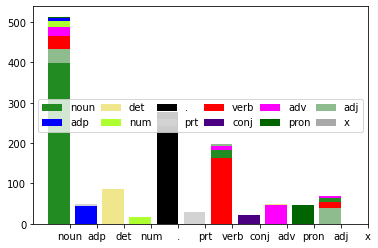

In [39]:
import lxmls.sequences.confusion_matrix as cm

confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, pred_test,
                                             len(corpus.tag_dict), crf_online.get_num_states())

cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict,
                            range(crf_online.get_num_states()), 'Confusion matrix')
